# Application: using Piven on yearpredictionMSD dataset

In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from piven.regressors import build_keras_piven
from piven.loss import piven_loss
from piven.metrics import mpiw, picp
from piven.transformers import PivenTransformedTargetRegressor
from piven.wrappers import PivenModelWrapper
from piven.metrics import coverage, pi_distance
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse
from sklearn.compose import TransformedTargetRegressor

dpath = Path("data/YearPredictionMSD.txt")

In [2]:
records = []
with dpath.open("r") as infile:
    for line in infile.readlines():
        line_split = line.replace("\n", "").split(",")
        year = int(line_split[0])
        inputs = [*map(lambda x: float(x), line_split[1:])]
        records.append([year] + inputs)

In [3]:
df = pd.DataFrame(records)

In [4]:
df.columns = ["year"] + [f"feature_{i}" for i in range(1, df.shape[-1])]

In [5]:
df.head()

,year,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_81,feature_82,feature_83,feature_84,feature_85,feature_86,feature_87,feature_88,feature_89,feature_90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


In [6]:
df.shape

(515345, 91)

In [7]:
# As per instructions https://archive.ics.uci.edu/ml/datasets/YearPredictionMSD
train_samples = 463715
train = df.iloc[:train_samples,:]
test = df.iloc[train_samples:, :]

train_y = train.year.values
test_y = test.year.values
train_x = train.iloc[:, 1:].values
test_x = test.iloc[:, 1:].values

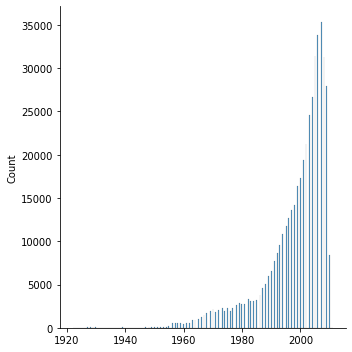

In [8]:
sns.displot(train_y)
plt.show()

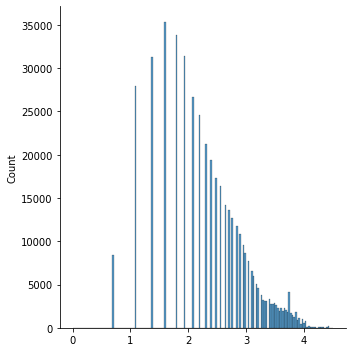

In [9]:
# Transform outcome variable (left-skewed)

max_out_train = np.max(train_y)

def reflect_and_log(x):
    return np.log(1 + max_out_train - train_y)

def exp_and_reflect(x):
    xexp = np.exp(x)
    return max_out_train + 1 - xexp

train_y_transformed = reflect_and_log(train_y)
test_y_transformed = reflect_and_log(train_y)

sns.displot(train_y_transformed)
plt.show()

In [19]:
# Make build function for the model wrapper
def piven_model(input_dim, dense_units, dropout_rate, lambda_=10.0, lr=0.0001):
    model = build_keras_piven(input_dim=input_dim,
                             dense_units=dense_units,
                             dropout_rate=dropout_rate,
                             activation="relu",
                             bias_init_low=-3,
                             bias_init_high=3)
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=lr),
                  loss=piven_loss(lambda_, 100.0, 0.05),
                  metrics=[picp, mpiw])
    return model

In [20]:
# Set up the model using the MLP that comes with piven
# Using best hyperparamter values (see hyperparameter optimization below.)
model = PivenModelWrapper(build_fn=piven_model, 
                          input_dim=train_x.shape[-1], 
                          dense_units=(64,32), 
                          dropout_rate=(0.0,0.0),
                          lambda_=34.75,
                          lr=0.00056)

In [21]:
# Put model in pipeline
pipeline = Pipeline([
    ("preprocess", StandardScaler()),
    ("model", model)
])

In [22]:
# Finally, normalize the output target
model_ttr = PivenTransformedTargetRegressor(
    regressor=pipeline,
    transformer=StandardScaler()
)

In [23]:
# Fit
h = model_ttr.fit(train_x, train_y_transformed, model__epochs=15, model__validation_split=0.2, model__batch_size=64)

Epoch 1/15
5797/5797 [==============================] - 6s 991us/step - loss: 6.4926 - picp: 0.9286 - mpiw: 4.3713 - val_loss: 5.3230 - val_picp: 0.9398 - val_mpiw: 3.6475
Epoch 2/15
5797/5797 [==============================] - 6s 1ms/step - loss: 4.6498 - picp: 0.9405 - mpiw: 3.5671 - val_loss: 5.0945 - val_picp: 0.9397 - val_mpiw: 3.3859
Epoch 3/15
5797/5797 [==============================] - 6s 953us/step - loss: 4.3462 - picp: 0.9424 - mpiw: 3.3739 - val_loss: 5.0562 - val_picp: 0.9358 - val_mpiw: 3.2162
Epoch 4/15
5797/5797 [==============================] - 5s 945us/step - loss: 4.1958 - picp: 0.9432 - mpiw: 3.2705 - val_loss: 4.8401 - val_picp: 0.9419 - val_mpiw: 3.2247
Epoch 5/15
5797/5797 [==============================] - 6s 952us/step - loss: 4.1271 - picp: 0.9426 - mpiw: 3.2050 - val_loss: 4.8282 - val_picp: 0.9440 - val_mpiw: 3.1851
Epoch 6/15
5797/5797 [==============================] - 5s 936us/step - loss: 4.0620 - picp: 0.9426 - mpiw: 3.1572 - val_loss: 5.1064 - val_pi

In [24]:
ypred, y_pi_low, y_pi_high = model_ttr.predict(test_x, return_prediction_intervals=True)

In [25]:
# Back-transform the predictions and PIs
def back_transform(x, max_train):
    xexp = np.exp(x)
    return max_train + 1 - xexp
ypred = back_transform(ypred, max_out_train)
# Need to reverse the bounds
y_pi_low_t = back_transform(y_pi_high, max_out_train)
y_pi_high_t = back_transform(y_pi_low, max_out_train)

In [26]:
coverage(test_y, y_pi_low_t, y_pi_high_t)

0.9433275227580864

In [27]:
pi_distance(y_pi_low_t, y_pi_high_t)

30.015314

In [28]:
df_res = pd.DataFrame({
    "true":test_y,
    "pred":ypred,
    "pi_low":y_pi_low_t,
    "pi_high":y_pi_high_t
})

In [29]:
print(mae(test_y, ypred))
print(np.sqrt(mse(test_y, ypred)))

6.096463389214725
9.31378158426549


In [30]:
col_out = (y_pi_low_t <= test_y) & (test_y <= y_pi_high_t)
colmap = np.array(["green" if cov else "red" for cov in col_out])

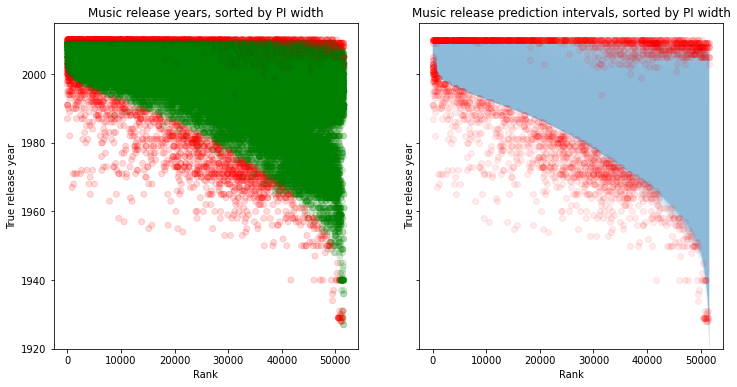

In [31]:
pi_width_sorted_idx = np.argsort(y_pi_high_t - y_pi_low_t)
test_y_sorted = test_y[pi_width_sorted_idx]
colmap_sorted = colmap[pi_width_sorted_idx]

fig, ax = plt.subplots(1,2, figsize=(12,6), sharey=True, sharex=True)
ax[0].scatter(range(test_y.shape[0]), test_y_sorted, c=colmap_sorted,alpha=0.15)
ax[0].set_ylim(1920, 2015)
ax[0].set_title("Music release years, sorted by PI width")
ax[0].set_xlabel("Rank")
ax[0].set_ylabel("True release year")

pred_wrong = test_y_sorted[colmap_sorted == "red"]
year_wrong = np.array([*range(test_y.shape[0])])[colmap_sorted == "red"]
ax[1].fill_between(
    range(test_y.shape[0]),
    y_pi_low_t[pi_width_sorted_idx],
    y_pi_high_t[pi_width_sorted_idx],
    alpha=0.5
)
ax[1].scatter(year_wrong, pred_wrong, c="r", alpha=0.08)
ax[1].set_ylim(1920, 2015)
ax[1].set_title("Music release prediction intervals, sorted by PI width")
ax[1].set_xlabel("Rank")
ax[1].set_ylabel("True release year")

plt.show()

In [32]:
outliers = df_res[df_res.true < 1960]
coverage(outliers.true, outliers.pi_low, outliers.pi_high)

outliers.head(10)

/opt/anaconda3/envs/pivenregressor/lib/python3.7/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


,true,pred,pi_low,pi_high
70,1940,1993.153320,1940.832275,2007.163696
72,1940,1997.105835,1955.748779,2008.800781
73,1940,1997.183105,1956.438354,2008.451172
922,1945,1995.810791,1946.123535,2008.840088
923,1945,1984.705566,1935.346313,2003.342651
924,1945,1985.131470,1928.658691,2005.571167
1006,1959,1997.274780,1948.678833,2008.888550
1009,1959,1991.809937,1942.950317,2007.603882
1010,1959,1993.825928,1948.100952,2008.491333
1011,1959,2002.406494,1978.350830,2009.134888


In [33]:
pi_distance(outliers.pi_low, outliers.pi_high)

58.41817

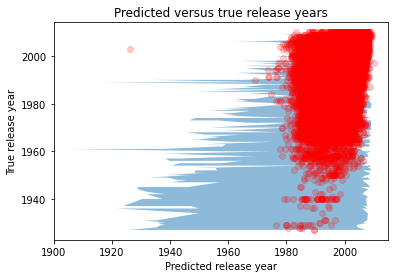

In [48]:
idx_sort = np.argsort(test_y)
plt.fill_betweenx(
    test_y[idx_sort],
    y_pi_low_t[idx_sort],
    y_pi_high_t[idx_sort],
    alpha=0.5
)
plt.scatter(ypred[idx_sort], test_y[idx_sort], c="r", alpha=0.2)
plt.xlim(1900, 2015)
plt.title("Predicted versus true release years")
plt.xlabel("Predicted release year")
plt.ylabel("True release year")
plt.show()

The PI are getting smaller as the true release year gets closer to 2012. This makes sense as the bulk of the data is there.

## With a regular MLP

In [158]:
def mlp_model(input_dim):    
    i = tf.keras.layers.Input(shape=(input_dim,))
    x = tf.keras.layers.Dense(
        64,
        activation="relu",
    )(i)
    x = tf.keras.layers.Dense(
        32,
        activation="relu",
    )(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    o = tf.keras.layers.Dense(
        1,
        activation="relu",
    )(x)
    model = tf.keras.models.Model(inputs=i, outputs=[o], name="MLP")
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
                  loss="mse")
    return model
mlp = tf.keras.wrappers.scikit_learn.KerasRegressor(
    build_fn=mlp_model,
    input_dim=train_x.shape[-1]
)
pipeline = Pipeline([
    ("preprocess", StandardScaler()),
    ("model", mlp)
])
mlp_ttr = TransformedTargetRegressor(
    regressor=pipeline,
    transformer=StandardScaler()
)

In [159]:
mlp_ttr.fit(train_x, train_y_transformed, model__epochs=10, model__validation_split=0.2, model__batch_size=64)

Epoch 1/10
5797/5797 [==============================] - 5s 742us/step - loss: 0.9645 - val_loss: 0.8523
Epoch 2/10
5797/5797 [==============================] - 4s 708us/step - loss: 0.8385 - val_loss: 0.8258
Epoch 3/10
5797/5797 [==============================] - 4s 757us/step - loss: 0.8156 - val_loss: 0.8170
Epoch 4/10
5797/5797 [==============================] - 4s 714us/step - loss: 0.8086 - val_loss: 0.8113
Epoch 5/10
5797/5797 [==============================] - 4s 710us/step - loss: 0.7979 - val_loss: 0.8069
Epoch 6/10
5797/5797 [==============================] - 4s 725us/step - loss: 0.7939 - val_loss: 0.8056
Epoch 7/10
5797/5797 [==============================] - 4s 723us/step - loss: 0.7916 - val_loss: 0.8031
Epoch 8/10
5797/5797 [==============================] - 4s 730us/step - loss: 0.7926 - val_loss: 0.8031
Epoch 9/10
5797/5797 [==============================] - 5s 806us/step - loss: 0.7885 - val_loss: 0.8011
Epoch 10/10
5797/5797 [==============================] - 5s 819u

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocess',
                                                      StandardScaler()),
                                                     ('model',
                                                      <tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7fdf0a4d3d10>)]),
                           transformer=StandardScaler())

In [166]:
ypred_mlp = mlp_ttr.predict(test_x)
ypred_mlp = back_transform(ypred_mlp, max_out_train)

In [167]:
print(mae(test_y, ypred_mlp))
print(np.sqrt(mse(test_y, ypred_mlp)))

6.463031976416479
9.322798428760485


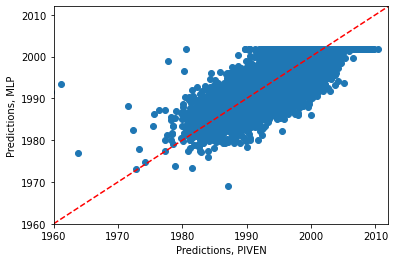

In [168]:
plt.scatter(ypred, ypred_mlp)
plt.xlim(1960, 2012)
plt.ylim(1960, 2012)
plt.xlabel("Predictions, PIVEN")
plt.ylabel("Predictions, MLP")
plt.plot(range(1960, 2015), range(1960, 2015), '--', c="r")
plt.show()

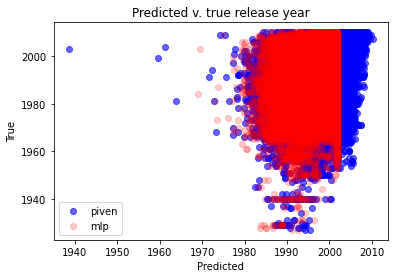

In [169]:
plt.scatter(ypred, test_y, c="b", alpha=0.6, label="piven")
plt.scatter(ypred_mlp, test_y, c="r", alpha=0.2, label="mlp")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.legend()
plt.title("Predicted v. true release year")
plt.show()

## Hyperparameter optimization

In [135]:
import optuna

def objective(trial: optuna.trial.Trial):
    lambda_ = trial.suggest_float("lambda_", 1.0, 35.0)
    lr = trial.suggest_loguniform("lr", 1e-4, 0.001)
    seed = trial.suggest_int("seed", 162, 9999999)
    np.random.seed(seed)
    # Split train from test data
    x_ind = [*range(train_x.shape[0])]
    np.random.shuffle(x_ind)
    train_x_trial, val_x_trial = train_x[:42000, :], train_x[42000:, :]
    train_y_trial, val_y_trial = train_y_transformed[:42000], train_y_transformed[42000:]
    max_train_out = np.max(train_y_trial)
    # Instantiate model
    model = PivenModelWrapper(build_fn=piven_model, 
                              input_dim=train_x.shape[-1], 
                              dense_units=(64,32), 
                              dropout_rate=(0.0,0.0),
                              lambda_=lambda_,
                              lr=lr)
    model = PivenTransformedTargetRegressor(regressor=model,
                                            transformer=StandardScaler())
    # Fit
    model_ttr.fit(train_x, train_y_transformed, model__epochs=15, 
                  model__validation_split=0.2, model__batch_size=64,
                  model__verbose=False)
    history = model_ttr.regressor_["model"].history
    
    trial.set_user_attr("picp", history.get("val_picp")[-1])
    trial.set_user_attr("mpiw", history.get("val_mpiw")[-1])
    # Return model loss
    return history.get("val_loss")[-1]

In [136]:
experiment = optuna.create_study(direction="minimize",
                                 study_name="piven_year_msd",
                                 storage='sqlite:///data/experiment_results.db',
                                 load_if_exists=True)

[I 2020-12-24 15:40:41,788] Using an existing study with name 'piven_year_msd' instead of creating a new one.


In [138]:
experiment.optimize(objective, n_trials=25)

[I 2020-12-24 15:43:49,243] Trial 3 finished with value: 4.2744317054748535 and parameters: {'lambda_': 12.622594924209023, 'lr': 0.00030624163726626174, 'seed': 6345073}. Best is trial 2 with value: 4.231029033660889.
[I 2020-12-24 15:45:03,264] Trial 4 finished with value: 4.2112603187561035 and parameters: {'lambda_': 6.893773962032438, 'lr': 0.0009159885443683169, 'seed': 5125104}. Best is trial 4 with value: 4.2112603187561035.
[I 2020-12-24 15:46:14,775] Trial 5 finished with value: 4.23484992980957 and parameters: {'lambda_': 34.26417184606055, 'lr': 0.0001323475189549869, 'seed': 3450525}. Best is trial 4 with value: 4.2112603187561035.
[I 2020-12-24 15:47:26,709] Trial 6 finished with value: 4.177648544311523 and parameters: {'lambda_': 26.03297611152667, 'lr': 0.0006461449665576924, 'seed': 4993623}. Best is trial 6 with value: 4.177648544311523.
[I 2020-12-24 15:48:42,075] Trial 7 finished with value: 4.180824279785156 and parameters: {'lambda_': 12.959524801168385, 'lr': 0.